In [1]:
from SplitWindows import SplitWindows
from AttentionArea import TemporalAttention , SpatialAttention , DynamicMatrix , AttentionBlock
from torch_geometric.nn import GCNConv
from Config import CONFIG
from Dataset import TimeSDataset
import engine

import numpy as np
import pandas as pd 
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader

Config = CONFIG()
device = "cuda" if torch.cuda.is_available else "cpu"

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Config.T , Config.P_2 , Config.K_E , Config.NUM_LAYER

(39, 22, 39, 10)

In [3]:
### Write the Main Class

class DynDeepNet(nn.Module):
    def __init__(self ):
        super().__init__()
        # Define Clf token
        self.CLFToken = torch.nn.Parameter(torch.rand(1, Config.T_prim, 1))
        # Define Temporal Attention
        self.TAttention = TemporalAttention (Config.NUM_H1 ,Config.V * Config.P_2 , Config.HIDDEN_DIM)
        # Define Spatial Attention 
        self.SAttention = SpatialAttention()
        # Define Dynamic Matrix
        self.Dm = DynamicMatrix()
        # Define GCN Layer
        self.gcn_layer = GCNConv(in_channels=Config.P_2, out_channels=Config.K_F)
        # Define Final Encoder layers
        self.Transformer = nn.Sequential(*[AttentionBlock(Config.K_E * Config.K_F, Config.HIDDEN_DIM, Config.NUM_H2, Config.DROP_OUT) for _ in range(Config.NUM_LAYER)])
        self.Mlp_head = nn.Sequential(
            nn.LayerNorm(Config.K_E * Config.K_F),
            nn.Linear(Config.K_E * Config.K_F, Config.NUM_CLASS)
        )
        self.Dropout = nn.Dropout(Config.DROP_OUT)
        self.Flatten = nn.Flatten(2,-1)
        self.MeanDynamicMatrix = 0
        
    def forward(self,x):
        ### Input : (B , T_Prim , V)
        B , _ , _ = x.shape
        ## ADD CLF TOKEN
        CLFToken = self.CLFToken.repeat(B, 1 ,1)
        # print(f"CLFToken Gradeient {self.CLFToken} , {self.CLFToken.shape}")
        x = torch.concatenate([CLFToken, x], axis=-1)
        
        ## Convert Signal Serie to the Window Signal
        x = SplitWindows(x)  ## OutPut : (B , T , V ,P)
        ## Temporal Transformer
        x = self.TAttention(x)  ## OutPut : (B , K_E , V , P_2)
        ## Spatial Attention
        x = self.SAttention(x)    ## OutPut : (B , K_E , V , P_2)
        ## Dynamic Matrix
        A = self.Dm(x)           ## OutPut  : (B , K_E , V , V)
        self.MeanDynamicMatrix = A
        ## GCN Layer
        BatchTensor = torch.empty(B, Config.K_E, Config.V, Config.K_F, dtype=x.dtype, device=x.device)
        # Iterate over each graph in the batch
        for i in range(B):
            # Extract the adjacency matrix for the current graph
            adj_i = A[i]  # Shape (T, V, V)
            for t in range(Config.T):
                # Get the edge indices and weights for the current time step
                edge_index = adj_i[t].nonzero(as_tuple=False).T  # Shape (2, E)
                edge_weights = adj_i[t][edge_index[0], edge_index[1]]  # Shape (E,)
                # Select the corresponding node features for the current time step
                x_t = x[i][t]
                # Apply the GCN layer
                x_t = self.gcn_layer(x_t, edge_index, edge_weight=edge_weights)
                # Store the output for the current time step
                # out.append(x_t)
            BatchTensor[i , t ] = x_t
        
        # Stack the output to get the final representation
        x = BatchTensor  ## OUTPUT : (B , K_E , V , K_F) 
        # Transpose
        x = x.transpose(1,2)  ## OUTPUT : (B , V , K_E , K_F)
        # Flatten
        x = self.Flatten(x)  ## OUTPUT  : (B , V , K_E * K_F)
        # Drop Out
        # x = self.Dropout(x)
        # Apply Final Encoder
        x = x.transpose(0,1)
        x = self.Transformer(x)   ## OUTPUT : (V , B , K_E * K_F)
        # Apply Linear Head
        cls = x[0]
        # print(cls)
        return self.Mlp_head(cls)

Model = DynDeepNet()
        

## Define Dataset & DataLoaders

In [4]:
TrainDataset = TimeSDataset("../Data/AAL/Train","Gender",label_path="../Data/Behavioral-HCP.csv")
TestDataset = TimeSDataset("../Data/AAL/Test","Gender",label_path="../Data/Behavioral-HCP.csv")

In [5]:
TrainDataLoader = DataLoader(TrainDataset ,Config.B ,shuffle = False ,num_workers= 8)
TestDataLoader = DataLoader(TestDataset ,Config.B ,shuffle = False ,num_workers= 8)

## Train the model

In [6]:
### 
LR = 0.01
Pivot = 65
Part = 1
Epochs = 40
save_weights = True
###
optimizer = torch.optim.AdamW(Model.parameters() , LR)
loss_fn = torch.nn.CrossEntropyLoss()

  0%|                                                                                                                                                                                                                | 0/40 [00:00<?, ?it/s]

CLFToken Gradeient Parameter containing:
tensor([[[0.7080],
         [0.0346],
         [0.6164],
         ...,
         [0.5068],
         [0.1836],
         [0.1720]]], device='cuda:0', requires_grad=True)


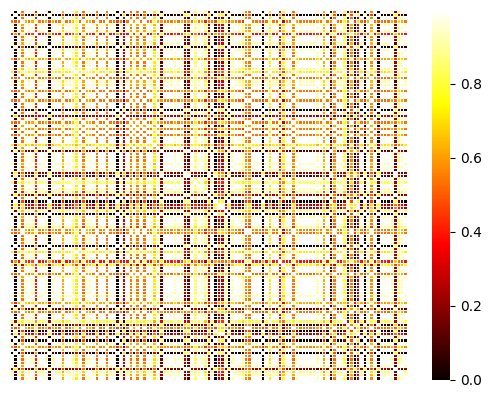

  2%|█████                                                                                                                                                                                                   | 1/40 [00:37<24:30, 37.70s/it]

Epoch: 1 | train_loss: 1.2765 | train_acc: 0.5511 | test_loss: 0.8561 | test_acc: 0.4886
CLFToken Gradeient Parameter containing:
tensor([[[ 0.5752],
         [-0.0670],
         [ 0.4722],
         ...,
         [ 0.4980],
         [ 0.1804],
         [ 0.1690]]], device='cuda:0', requires_grad=True)


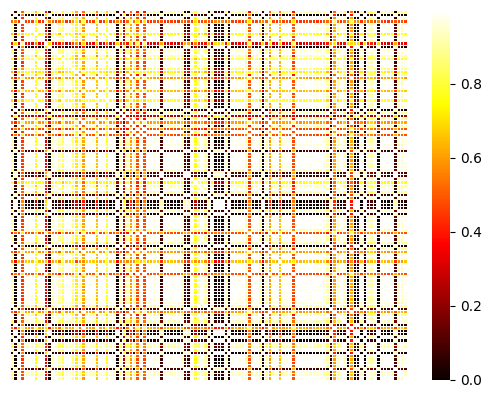

  5%|██████████                                                                                                                                                                                              | 2/40 [01:15<23:52, 37.70s/it]

Epoch: 2 | train_loss: 4.4658 | train_acc: 0.5369 | test_loss: 9.0427 | test_acc: 0.5227
CLFToken Gradeient Parameter containing:
tensor([[[ 0.5799],
         [-0.0522],
         [ 0.4749],
         ...,
         [ 0.4893],
         [ 0.1772],
         [ 0.1660]]], device='cuda:0', requires_grad=True)


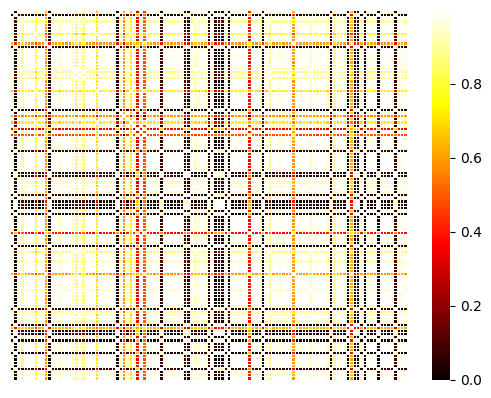

  8%|███████████████                                                                                                                                                                                         | 3/40 [01:53<23:16, 37.73s/it]

Epoch: 3 | train_loss: 2.2835 | train_acc: 0.4972 | test_loss: 7.0884 | test_acc: 0.4886
CLFToken Gradeient Parameter containing:
tensor([[[ 0.5768],
         [-0.0355],
         [ 0.4827],
         ...,
         [ 0.4807],
         [ 0.1741],
         [ 0.1631]]], device='cuda:0', requires_grad=True)


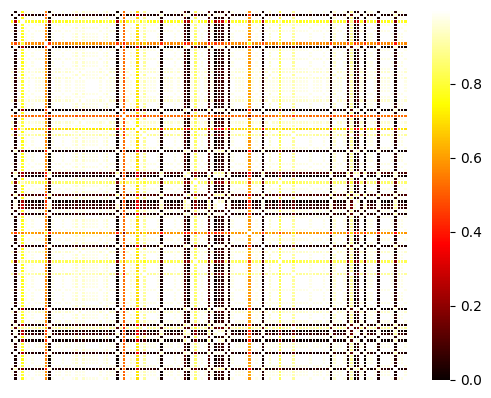

 10%|████████████████████                                                                                                                                                                                    | 4/40 [02:31<22:40, 37.80s/it]

Epoch: 4 | train_loss: 2.1300 | train_acc: 0.4972 | test_loss: 5.4065 | test_acc: 0.4773
CLFToken Gradeient Parameter containing:
tensor([[[ 0.5616],
         [-0.0425],
         [ 0.4670],
         ...,
         [ 0.4724],
         [ 0.1711],
         [ 0.1603]]], device='cuda:0', requires_grad=True)


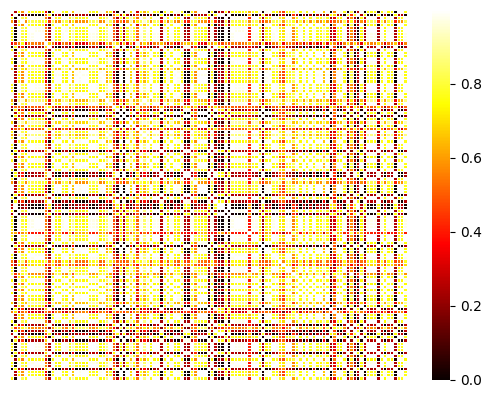

 12%|█████████████████████████                                                                                                                                                                               | 5/40 [03:09<22:06, 37.90s/it]

Epoch: 5 | train_loss: 1.3984 | train_acc: 0.5511 | test_loss: 4.8940 | test_acc: 0.5341
CLFToken Gradeient Parameter containing:
tensor([[[ 0.4012],
         [-0.1527],
         [ 0.3878],
         ...,
         [ 0.4641],
         [ 0.1681],
         [ 0.1575]]], device='cuda:0', requires_grad=True)


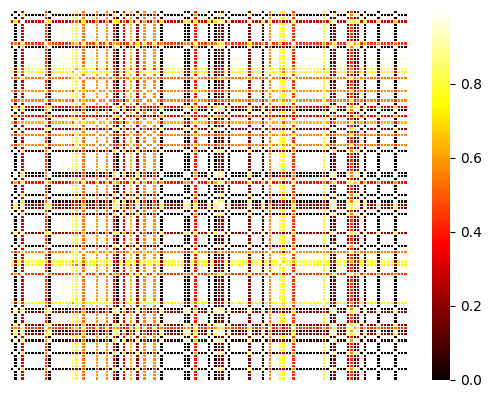

 15%|██████████████████████████████                                                                                                                                                                          | 6/40 [03:47<21:36, 38.12s/it]

Epoch: 6 | train_loss: 1.3680 | train_acc: 0.5085 | test_loss: 0.7696 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[ 0.4480],
         [-0.0739],
         [ 0.4765],
         ...,
         [ 0.4560],
         [ 0.1652],
         [ 0.1548]]], device='cuda:0', requires_grad=True)


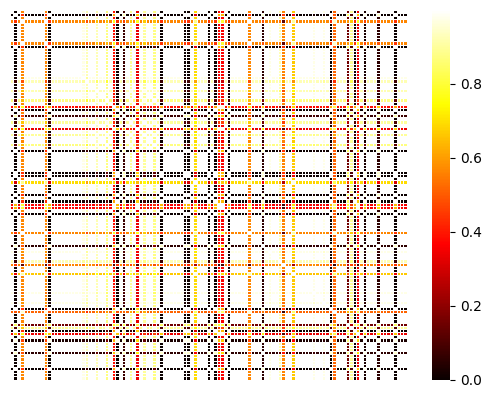

 18%|███████████████████████████████████                                                                                                                                                                     | 7/40 [04:25<20:57, 38.10s/it]

Epoch: 7 | train_loss: 1.0995 | train_acc: 0.5483 | test_loss: 3.7994 | test_acc: 0.4432
CLFToken Gradeient Parameter containing:
tensor([[[ 0.4407],
         [-0.0734],
         [ 0.4700],
         ...,
         [ 0.4481],
         [ 0.1623],
         [ 0.1521]]], device='cuda:0', requires_grad=True)


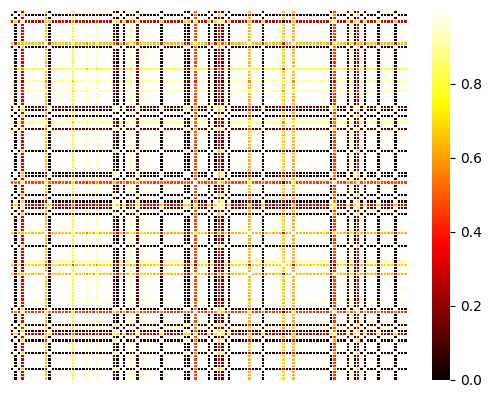

 20%|████████████████████████████████████████                                                                                                                                                                | 8/40 [05:03<20:17, 38.06s/it]

Epoch: 8 | train_loss: 0.9509 | train_acc: 0.5284 | test_loss: 1.7119 | test_acc: 0.5000
CLFToken Gradeient Parameter containing:
tensor([[[0.5724],
         [0.0740],
         [0.6270],
         ...,
         [0.4402],
         [0.1595],
         [0.1494]]], device='cuda:0', requires_grad=True)


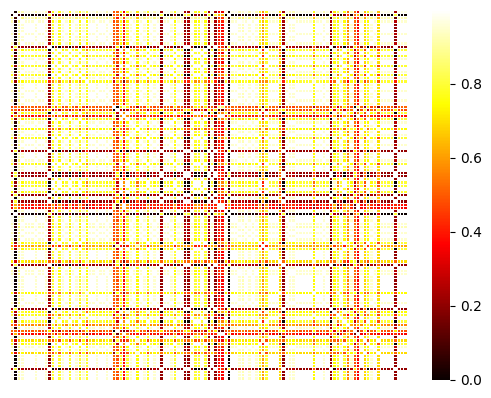

 22%|█████████████████████████████████████████████                                                                                                                                                           | 9/40 [05:42<19:46, 38.27s/it]

Epoch: 9 | train_loss: 0.8882 | train_acc: 0.5455 | test_loss: 2.2203 | test_acc: 0.5114
CLFToken Gradeient Parameter containing:
tensor([[[0.5614],
         [0.0729],
         [0.6177],
         ...,
         [0.4326],
         [0.1567],
         [0.1468]]], device='cuda:0', requires_grad=True)


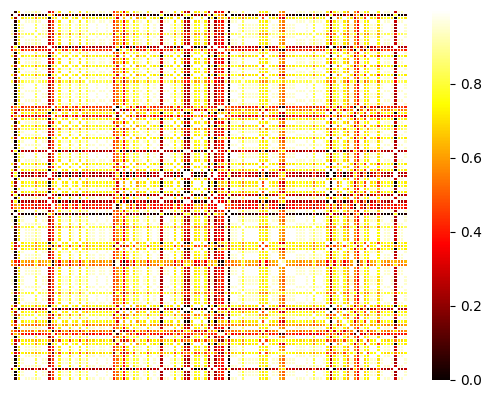

 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 10/40 [06:20<19:07, 38.26s/it]

Epoch: 10 | train_loss: 0.8840 | train_acc: 0.5284 | test_loss: 0.7279 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[0.5730],
         [0.0902],
         [0.6199],
         ...,
         [0.4250],
         [0.1539],
         [0.1442]]], device='cuda:0', requires_grad=True)


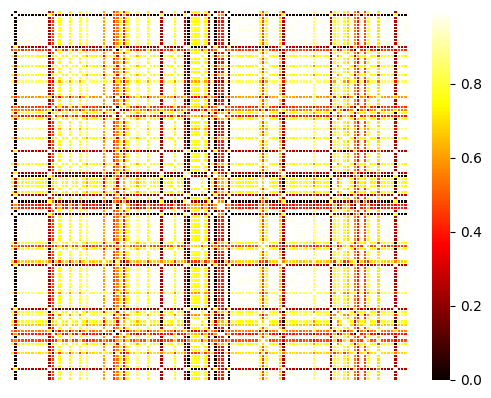

 28%|██████████████████████████████████████████████████████▋                                                                                                                                                | 11/40 [06:59<18:35, 38.45s/it]

Epoch: 11 | train_loss: 0.7316 | train_acc: 0.5170 | test_loss: 1.2446 | test_acc: 0.4545
CLFToken Gradeient Parameter containing:
tensor([[[0.6172],
         [0.1358],
         [0.6511],
         ...,
         [0.4176],
         [0.1513],
         [0.1417]]], device='cuda:0', requires_grad=True)


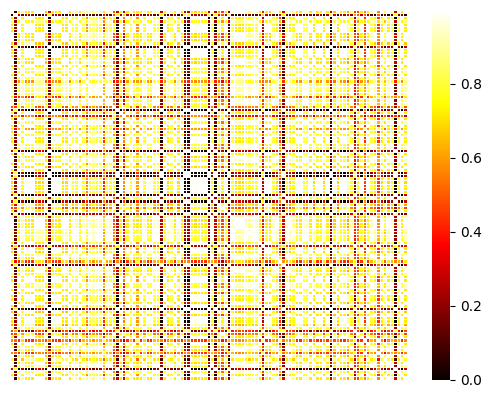

 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 12/40 [07:38<18:01, 38.62s/it]

Epoch: 12 | train_loss: 0.7788 | train_acc: 0.5199 | test_loss: 0.7286 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[0.6191],
         [0.1468],
         [0.6514],
         ...,
         [0.4103],
         [0.1486],
         [0.1392]]], device='cuda:0', requires_grad=True)


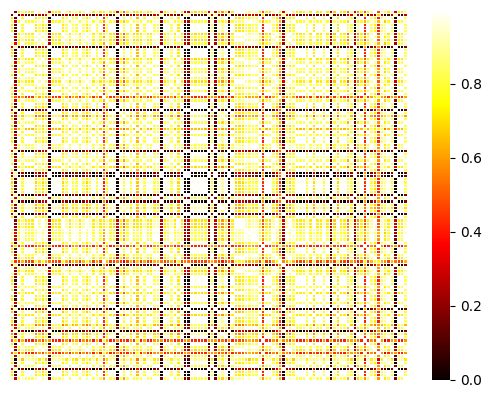

 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                      | 13/40 [08:16<17:18, 38.46s/it]

Epoch: 13 | train_loss: 0.7544 | train_acc: 0.5256 | test_loss: 0.7682 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[0.6020],
         [0.1386],
         [0.6396],
         ...,
         [0.4031],
         [0.1460],
         [0.1368]]], device='cuda:0', requires_grad=True)


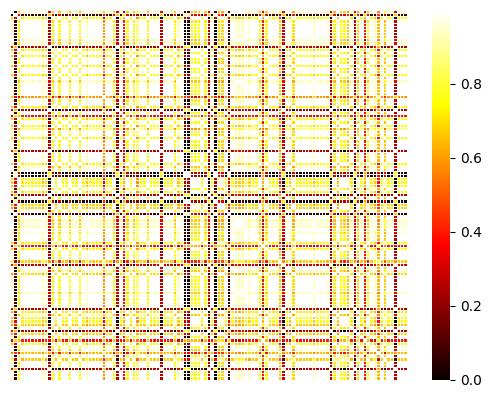

 35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 14/40 [08:54<16:36, 38.33s/it]

Epoch: 14 | train_loss: 0.7321 | train_acc: 0.5199 | test_loss: 0.7699 | test_acc: 0.4773
CLFToken Gradeient Parameter containing:
tensor([[[0.6857],
         [0.2294],
         [0.7634],
         ...,
         [0.3961],
         [0.1435],
         [0.1344]]], device='cuda:0', requires_grad=True)


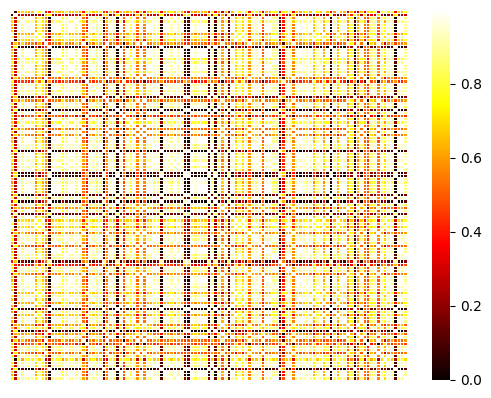

 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 15/40 [09:32<15:57, 38.31s/it]

Epoch: 15 | train_loss: 0.7296 | train_acc: 0.5511 | test_loss: 0.7299 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[0.6692],
         [0.1372],
         [0.5584],
         ...,
         [0.3892],
         [0.1410],
         [0.1321]]], device='cuda:0', requires_grad=True)


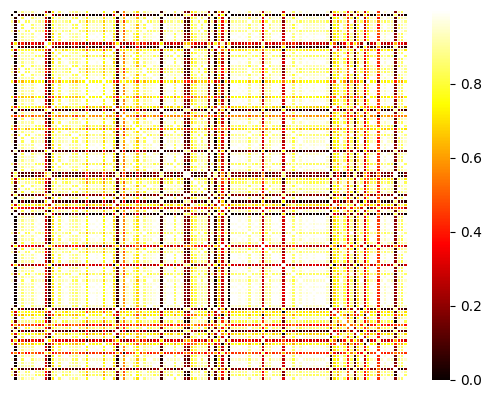

 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 16/40 [10:10<15:16, 38.18s/it]

Epoch: 16 | train_loss: 0.7339 | train_acc: 0.5284 | test_loss: 0.9571 | test_acc: 0.5114
CLFToken Gradeient Parameter containing:
tensor([[[0.7465],
         [0.1981],
         [0.5861],
         ...,
         [0.3824],
         [0.1385],
         [0.1298]]], device='cuda:0', requires_grad=True)


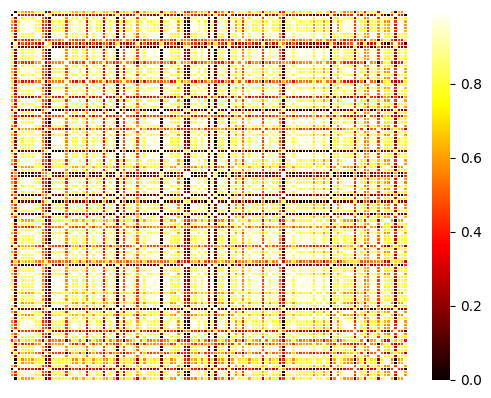

 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 17/40 [10:49<14:39, 38.22s/it]

Epoch: 17 | train_loss: 0.7402 | train_acc: 0.5540 | test_loss: 0.7819 | test_acc: 0.4773
CLFToken Gradeient Parameter containing:
tensor([[[0.7118],
         [0.1743],
         [0.5608],
         ...,
         [0.3757],
         [0.1361],
         [0.1275]]], device='cuda:0', requires_grad=True)


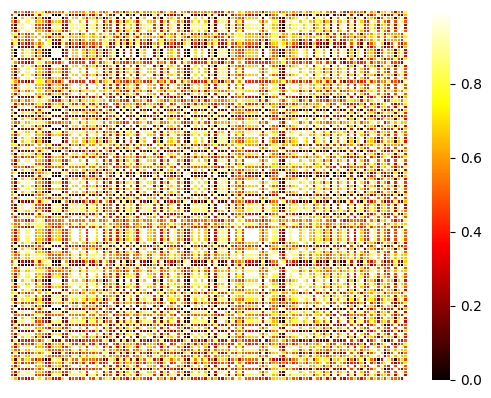

 45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 18/40 [11:27<13:58, 38.13s/it]

Epoch: 18 | train_loss: 0.7515 | train_acc: 0.5426 | test_loss: 0.6929 | test_acc: 0.5455
CLFToken Gradeient Parameter containing:
tensor([[[0.6146],
         [0.0470],
         [0.4181],
         ...,
         [0.3692],
         [0.1337],
         [0.1253]]], device='cuda:0', requires_grad=True)


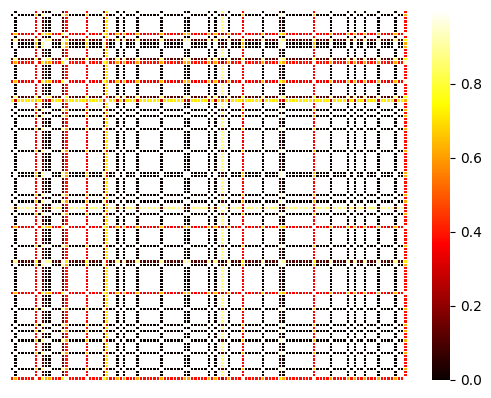

 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 19/40 [12:05<13:19, 38.09s/it]

Epoch: 19 | train_loss: 0.7521 | train_acc: 0.5369 | test_loss: 0.7144 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[0.5867],
         [0.0323],
         [0.3987],
         ...,
         [0.3627],
         [0.1314],
         [0.1231]]], device='cuda:0', requires_grad=True)


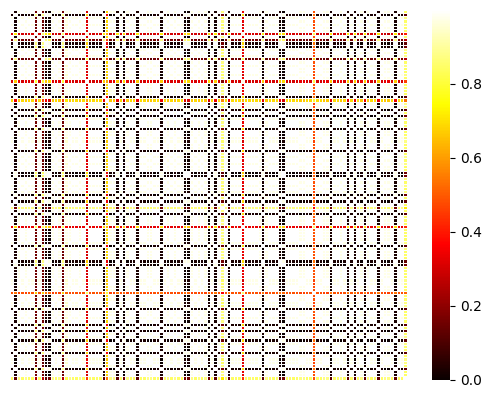

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 20/40 [12:45<12:53, 38.66s/it]

Epoch: 20 | train_loss: 0.7407 | train_acc: 0.5369 | test_loss: 0.8938 | test_acc: 0.4205
CLFToken Gradeient Parameter containing:
tensor([[[0.5722],
         [0.0304],
         [0.3919],
         ...,
         [0.3564],
         [0.1291],
         [0.1210]]], device='cuda:0', requires_grad=True)


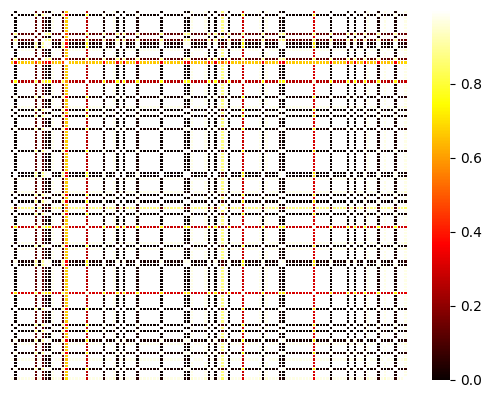

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 21/40 [13:24<12:21, 39.04s/it]

Epoch: 21 | train_loss: 0.7276 | train_acc: 0.5625 | test_loss: 0.8170 | test_acc: 0.4318
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2745],
         [-0.2626],
         [ 0.0886],
         ...,
         [ 0.3502],
         [ 0.1268],
         [ 0.1188]]], device='cuda:0', requires_grad=True)


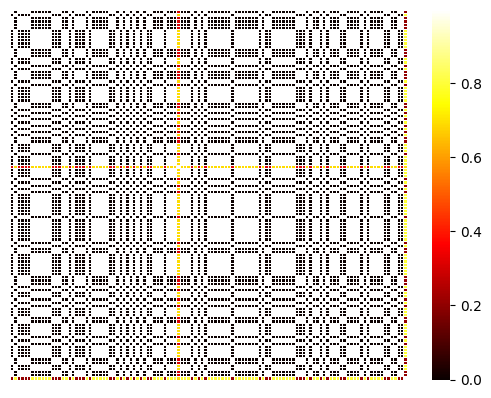

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 22/40 [14:02<11:36, 38.72s/it]

Epoch: 22 | train_loss: 0.7373 | train_acc: 0.5597 | test_loss: 0.7320 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2697],
         [-0.2580],
         [ 0.0871],
         ...,
         [ 0.3441],
         [ 0.1246],
         [ 0.1168]]], device='cuda:0', requires_grad=True)


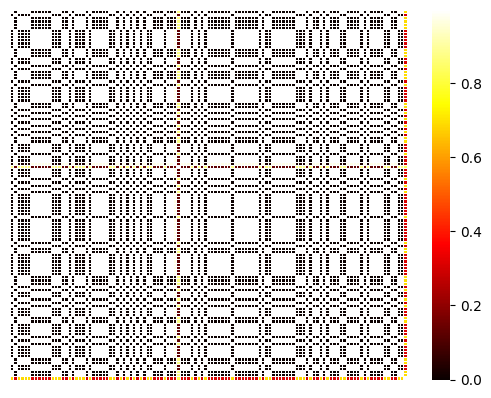

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 23/40 [14:41<10:55, 38.58s/it]

Epoch: 23 | train_loss: 0.7432 | train_acc: 0.5312 | test_loss: 0.7053 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2648],
         [-0.2536],
         [ 0.0855],
         ...,
         [ 0.3381],
         [ 0.1224],
         [ 0.1147]]], device='cuda:0', requires_grad=True)


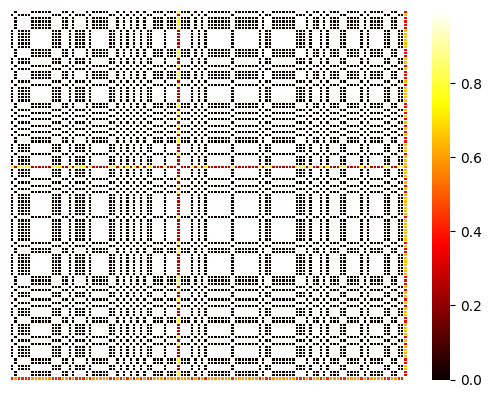

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 24/40 [15:19<10:15, 38.47s/it]

Epoch: 24 | train_loss: 0.7317 | train_acc: 0.5483 | test_loss: 0.7165 | test_acc: 0.4545
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2602],
         [-0.2492],
         [ 0.0840],
         ...,
         [ 0.3322],
         [ 0.1203],
         [ 0.1127]]], device='cuda:0', requires_grad=True)


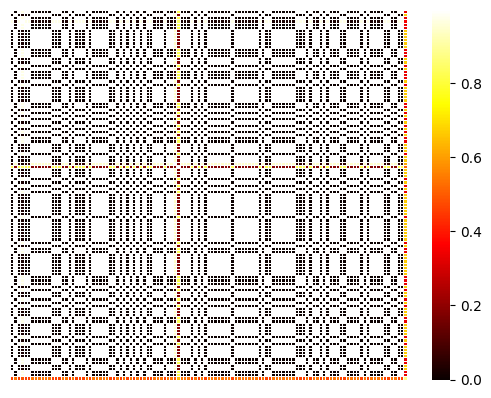

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 25/40 [15:57<09:34, 38.27s/it]

Epoch: 25 | train_loss: 0.7199 | train_acc: 0.5483 | test_loss: 0.7237 | test_acc: 0.4773
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2557],
         [-0.2448],
         [ 0.0825],
         ...,
         [ 0.3264],
         [ 0.1182],
         [ 0.1108]]], device='cuda:0', requires_grad=True)


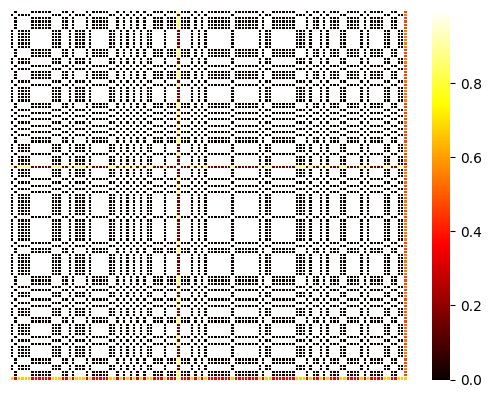

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 26/40 [16:35<08:54, 38.19s/it]

Epoch: 26 | train_loss: 0.7191 | train_acc: 0.5511 | test_loss: 0.7239 | test_acc: 0.4432
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2513],
         [-0.2405],
         [ 0.0811],
         ...,
         [ 0.3207],
         [ 0.1161],
         [ 0.1088]]], device='cuda:0', requires_grad=True)


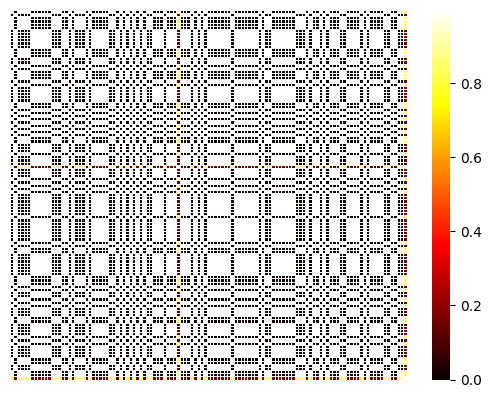

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 27/40 [17:13<08:16, 38.18s/it]

Epoch: 27 | train_loss: 0.7201 | train_acc: 0.5568 | test_loss: 0.6976 | test_acc: 0.5227
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2469],
         [-0.2361],
         [ 0.0801],
         ...,
         [ 0.3151],
         [ 0.1141],
         [ 0.1069]]], device='cuda:0', requires_grad=True)


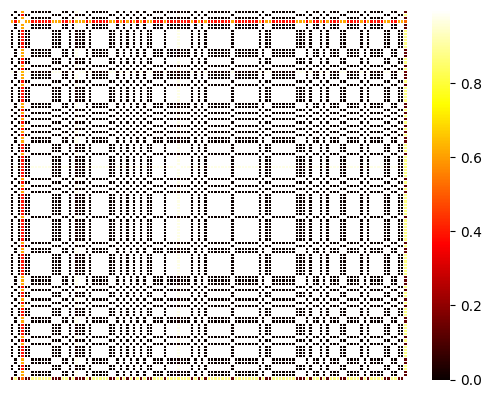

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 28/40 [17:51<07:39, 38.28s/it]

Epoch: 28 | train_loss: 0.7196 | train_acc: 0.5511 | test_loss: 0.7358 | test_acc: 0.4659
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2425],
         [-0.2321],
         [ 0.0786],
         ...,
         [ 0.3096],
         [ 0.1121],
         [ 0.1051]]], device='cuda:0', requires_grad=True)


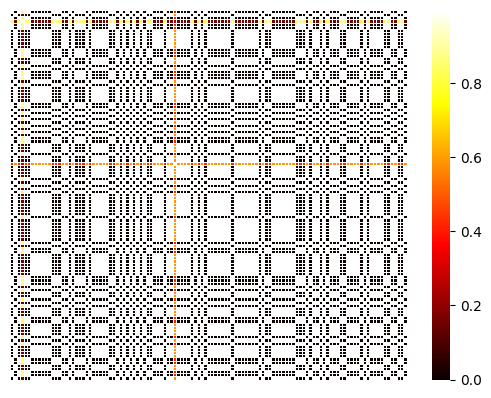

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 29/40 [18:30<07:00, 38.22s/it]

Epoch: 29 | train_loss: 0.7225 | train_acc: 0.5597 | test_loss: 0.7561 | test_acc: 0.5682
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2395],
         [-0.2271],
         [ 0.0794],
         ...,
         [ 0.3042],
         [ 0.1102],
         [ 0.1032]]], device='cuda:0', requires_grad=True)


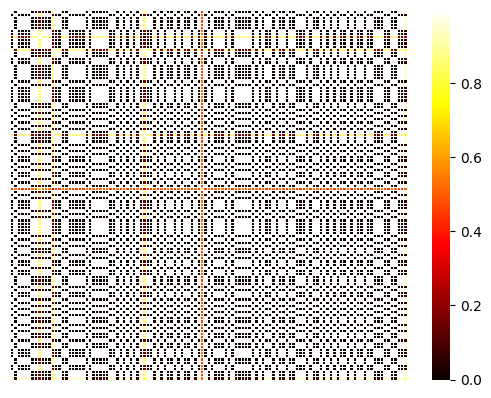

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 30/40 [19:08<06:22, 38.27s/it]

Epoch: 30 | train_loss: 0.7242 | train_acc: 0.5540 | test_loss: 0.8095 | test_acc: 0.5000
CLFToken Gradeient Parameter containing:
tensor([[[ 0.2354],
         [-0.2230],
         [ 0.0780],
         ...,
         [ 0.2989],
         [ 0.1083],
         [ 0.1014]]], device='cuda:0', requires_grad=True)


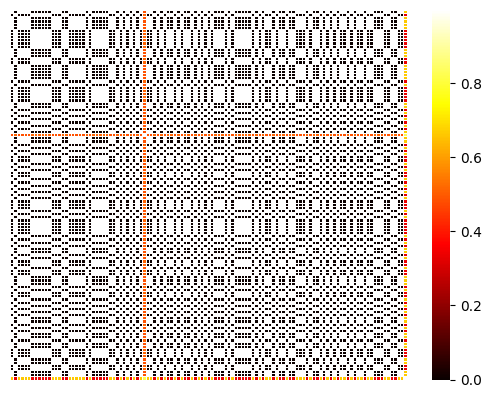

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 31/40 [19:46<05:43, 38.19s/it]

Epoch: 31 | train_loss: 0.7339 | train_acc: 0.5369 | test_loss: 0.8026 | test_acc: 0.5114


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 31/40 [20:21<05:54, 39.41s/it]


KeyboardInterrupt: 

In [7]:
results = engine.train(Model , 
                TrainDataLoader,
                TestDataLoader,
                optimizer,
                loss_fn,
                Pivot,
                Part,
                save_weights,
                Epochs,
                device)

In [8]:
import numpy as np

In [9]:
sample = np.random.randn(Config.B , Config.T , Config.V , Config.V)
sample.shape

(1, 133, 117, 117)

In [11]:
sample = sample.mean(axis=1).mean(axis=0)

In [12]:
sample.shape

(117, 117)

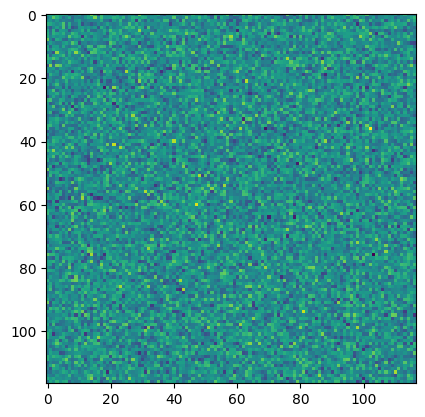

In [13]:
import matplotlib.pyplot as plt
plt.imshow(sample);

In [21]:
sample

torch.Size([1, 117, 117])

In [8]:
torch.ones(117).shape

torch.Size([117])

In [9]:
torch.diag(torch.ones(Config.V))

torch.Size([117, 117])

In [26]:
t = torch.tensor([[11,21,32],[54,67,45],[34,45,12],[23,10,2]],dtype=torch.float32)
t

tensor([[11., 21., 32.],
        [54., 67., 45.],
        [34., 45., 12.],
        [23., 10.,  2.]])

In [27]:
torch.nn.Sigmoid()(t)

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.8808]])

In [28]:
torch.nn.Softmax(dim=1)(t)

tensor([[7.5824e-10, 1.6701e-05, 9.9998e-01],
        [2.2603e-06, 1.0000e+00, 2.7895e-10],
        [1.6701e-05, 9.9998e-01, 4.6588e-15],
        [1.0000e+00, 2.2603e-06, 7.5825e-10]])